In [ ]:


import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os


from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load Phase 2 model


phase2_model_path = "/content/drive/MyDrive/health_classifier_phase2.keras"
model = load_model(phase2_model_path)
print("Phase 2 model loaded")

Phase 2 model loaded


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 838 variables whereas the saved optimizer has 842 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
#Prepare new dataset

DATA_DIR = "/content/drive/MyDrive/Healthy_unhealthy_once"

IMG_HEIGHT = 192
IMG_WIDTH = 192
BATCH_SIZE = 64

train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

train_data = train_gen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = train_gen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 15200 images belonging to 3 classes.
Found 3800 images belonging to 3 classes.


In [ ]:
#Adjust model to have 3 class output


#freeze base layers
for layer in model.layers[:-1]:
    layer.trainable = True

#get the previous feature output
x = model.layers[-2].output

# Create new output layer
new_output = layers.Dense(3, activation='softmax')(x)

#create new model
model3 = tf.keras.Model(inputs=model.input, outputs=new_output)


In [ ]:
#Compile Phase 3 model


model3.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Phase 3 model ready")


Phase 3 model ready


In [ ]:
# Train (Phase 3)


earlystop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.2)

history_phase3 = model3.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[earlystop, reduce_lr]
)


#Save Phase 3 model


model3.save('/content/drive/MyDrive/health_classifier_phase3.keras')
print("Phase 3 model saved to Google Drive")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 7988s 33s/step - accuracy: 0.4880 - loss: 0.9955 - val_accuracy: 0.6118 - val_loss: 0.8456 - learning_rate: 1.0000e-05
Epoch 2/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.6563 - loss: 0.7540 - val_accuracy: 0.7008 - val_loss: 0.6618 - learning_rate: 1.0000e-05
Epoch 3/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.6783 - loss: 0.6966 - val_accuracy: 0.6987 - val_loss: 0.6715 - learning_rate: 1.0000e-05
Epoch 4/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.6996 - loss: 0.6618 - val_accuracy: 0.6274 - val_loss: 0.8468 - learning_rate: 1.0000e-05
Epoch 5/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.7080 - loss: 0.6325 - val_accuracy: 0.7118 - val_loss: 0.6439 - learning_rate: 1.0000e-05
Epoch 6/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.7258 - loss: 0.6049 - val_accuracy: 0.7155 - val_loss: 0.6278 - learning_rate: 1.0000e-05
Epoch 7/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - a

In [ ]:
from google.colab import files

#download
files.download('/content/drive/MyDrive/health_classifier_phase3.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

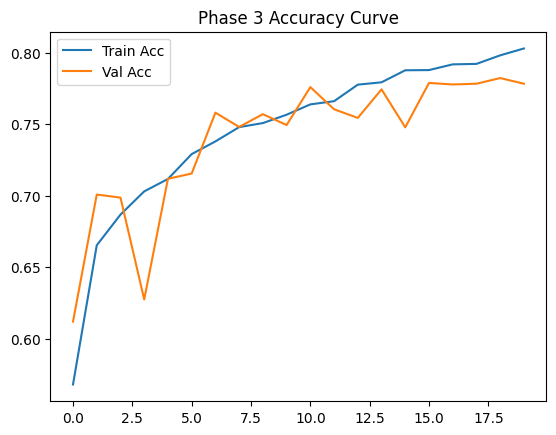

In [ ]:
#visualize Accuracy


plt.plot(history_phase3.history['accuracy'], label='Train Acc')
plt.plot(history_phase3.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Phase 3 Accuracy Curve")
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# Load your trained model from Drive or local path
model = load_model("/content/drive/MyDrive//health_classifier_phase3.keras")
print("Model loaded successfully!")



Model loaded successfully!


In [ ]:
# Data generator with validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

val_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # Important for correct y_true vs y_pred matching
)

Found 3800 images belonging to 3 classes.


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np
#Predict on validation data
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

#Get class labels
labels = list(val_generator.class_indices.keys())

#Print Accuracy and F1 Score
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {acc*100:.2f}%")
print(f"F1 Score (macro): {f1:.4f}")

#Detailed Report
print("\n🔎 Detailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


60/60 ━━━━━━━━━━━━━━━━━━━━ 859s 14s/step
Accuracy: 77.97%
F1 Score (macro): 0.7638

🔎 Detailed Classification Report:
              precision    recall  f1-score   support

    Healthy        0.78      0.85      0.81      1400
        Once       0.69      0.60      0.64      1000
   Unhealthy       0.84      0.84      0.84      1400

    accuracy                           0.78      3800
   macro avg       0.77      0.76      0.76      3800
weighted avg       0.78      0.78      0.78      3800

